In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import copy
import pandas as pd
import seaborn as sns
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import gym 
import gym_keygrid

In [3]:
DISPLAY_EVERY_N_EPISODES = 10

In [4]:
def states_display(state_seq, title=None, figsize=(10,10), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=None):
    state_array = np.array(state_seq).T

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap, ax=ax)
    
    if title is not None:
        ax.set_title(title)

    if ax is None:
        plt.show()
    else:
        return ax

In [5]:
def td_learning(policy, environment, alpha=0.1, alpha_factor=0.995, gamma=0.95, display=False):
    v_array = np.zeros(environment.states_n)
    v_array_tmp = np.zeros(environment.states_n)
    
    for e in range(env._max_episode_steps):
        value_function_history.append(v_array.copy())

        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        value_function_history.append(v_array.copy())
        alpha_history.append(alpha)

        s = environment.reset()
        d = False
        t = 0
        
        while (not d) and (t < environment._max_episode_steps):
            ns, r, d, _ = environment.step(policy[s])
            td_error = (r + gamma*v_array[ns] - v_array[s])
            v_array[s] = v_array[s] + alpha*td_error
                
            s = ns
            t+=1

        if display and e%DISPLAY_EVERY_N_EPISODES==0:
            states_display(v_array)
        
    return v_array

In [6]:
value_function_history = []
alpha_history = []

env = gym.make('keygrid-v0', grid_length=10)

policy = {s:0 for s in env.states}
for j in range(env.len):
    policy[(j, 0)] = 1
    policy[(j, 1)] = -1
policy[(env.key_pos, 0)] = 0

<AxesSubplot:title={'center':'Value function'}>

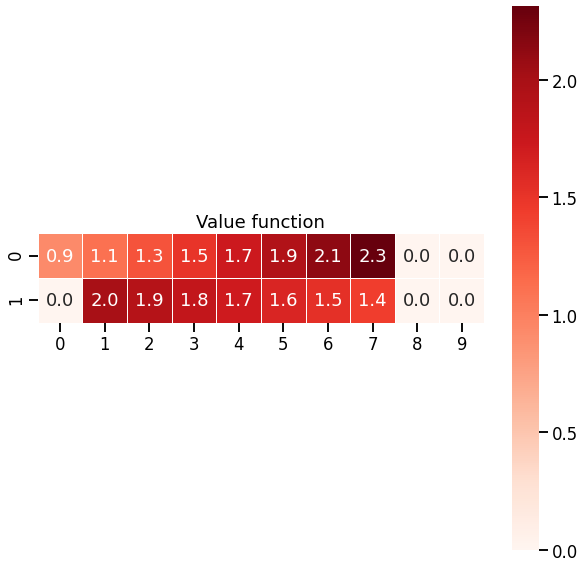

In [7]:
v_array = td_learning(policy, env, display=False)

states_display(v_array, title="Value function", cbar=True, cmap="Reds")

In [8]:
import random

def argmax_tiebreaker(arr):
    return np.random.choice(np.flatnonzero(arr == arr.max()))

def greedy_policy(state, q_array):
    action_idx = argmax_tiebreaker(q_array[state[0], state[1], :])
    return action_idx

def epsilon_greedy_policy(state, q_array, epsilon, actions):
    if np.random.rand() > epsilon:
        action_idx = greedy_policy(state, q_array)
    else:
        action_idx = random.choice(range(len(actions)))
    return action_idx

def qtable_display(q_array, title=None, figsize=(4,4), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    num_actions = q_array.shape[-1]

    global_figsize = list(figsize)
    global_figsize[0] *= num_actions
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)   # Sample figsize in inches

    for action_index in range(num_actions):
        ax = ax_list[action_index]
        state_seq = q_array[:,:,action_index]
        states_display(state_seq, title=f'Action {action_index}', figsize=figsize, annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=ax)

    plt.suptitle(title)
    plt.show()

def q_learning(environment, alpha=0.1, alpha_factor=0.9995, gamma=0.9, epsilon=0.5, num_episodes=5000, display=True):
    num_states = environment.states_n
    num_actions = environment.actions_n
    q_array = np.zeros([*num_states, num_actions])   # Initial Q table

    for episode_index in range(num_episodes):
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
            
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        # Update alpha
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        current_state = environment.reset()
        
        
        t = 0
        while t < env._max_episode_steps:
            action_idx = epsilon_greedy_policy(current_state, q_array, epsilon, env.actions)
            action = env.actions[action_idx]
            next_state, reward, final_state, _ = environment.step(action, render=False)
            
            td_error = reward+gamma*max(q_array[next_state[0], next_state[1], :]) - q_array[current_state[0], current_state[1], action_idx]
            q_array[current_state[0], current_state[1], action_idx] += alpha*(td_error)

            current_state = next_state
            
            if final_state:
                break

            t += 1

    return q_array

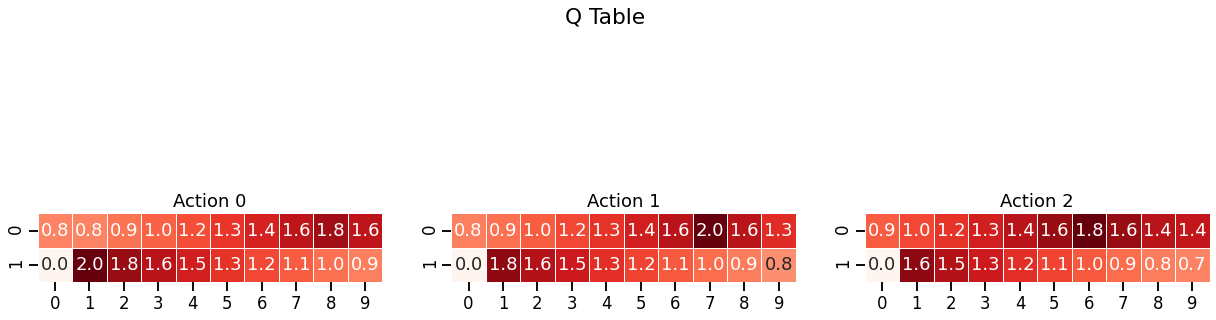

In [9]:
q_array_history = []
alpha_history = []

q_array = q_learning(env, display=False)

env.close()

qtable_display(q_array, title="Q Table", cbar=True, figsize=(7, 7))

In [10]:
action_map = np.vectorize(lambda x: env.actions[int(x)])
policy = action_map(np.argmax(q_array, axis=2))

<AxesSubplot:title={'center':'Q Table'}>

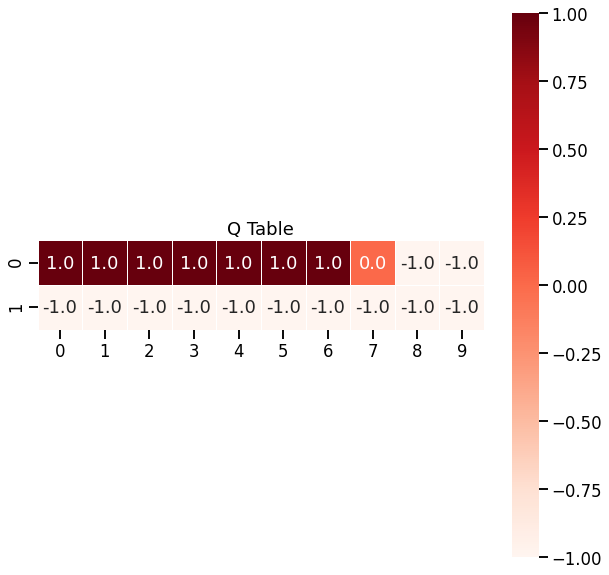

In [11]:
states_display(policy, title="Q Table", cbar=True)

In [12]:
class NN:
    def __init__(self, i=1, h1=64, h2=64, o=3):
        self.weights = {
            'w1': NN.xavier_init(i, h1),
            'b1': np.zeros((1, h1)),
            'w2': NN.xavier_init(h1, h2),
            'b2': np.zeros((1, h2)),
            'w3': NN.xavier_init(h2, o),
            'b3': np.zeros((1, o))
        }
    
    @staticmethod
    def xavier_init(h1, h2):
        glorot = 1.0*np.sqrt(6.0/(h1+h2))
        size = (h1, h2)
        return np.random.uniform(-glorot, glorot, size)
        
    @staticmethod
    def relu(l):
        return np.where(l<0, 0, l) 

    @staticmethod
    def softmax(l):
        e_x = np.exp(l - np.max(l))
        return e_x / e_x.sum(axis=-1)
        
    def forward(self, inp):
        w1 = self.weights['w1']
        b1 = self.weights['b1']
        w2 = self.weights['w2']
        b2 = self.weights['b2']
        w3 = self.weights['w3']
        b3 = self.weights['b3']
        
        l1 = NN.relu(inp @ w1 + b1)
        l2 = NN.relu(l1 @ w2 + b2)
        out = NN.softmax(l2 @ w3 + b3)
        
        return out

In [13]:
class Agent:
    def __init__(self, inp, h1, h2, out, mu_prob):
        self.inp = inp
        self.h1 = h1
        self.h2 = h2
        self.n_out = out
        self.mu_prob = mu_prob
        
        self.net = NN(inp, h1, h2, out)
        self.score = 0
        
    def reborn(self, parents):
        parent1, parent2 = parents
        for key in self.net.weights:
            mask = np.random.choice([0,1], size=self.net.weights[key].shape, p=[.5,.5])
            self.net.weights[key] = np.where(mask==1, parent1.net.weights[key], parent2.net.weights[key])
                
    def mutate(self):
        for key in self.net.weights:
            mask = np.random.choice([0,1], size=self.net.weights[key].shape, p=[1-self.mu_prob,self.mu_prob])
            
            random = NN.xavier_init(mask.shape[0],mask.shape[1])
            self.net.weights[key] = np.where(mask==1,self.net.weights[key]+random,self.net.weights[key])

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        
        return env.actions[np.argmax(self.net.forward(state))]

    def evaluate(self, env, pr=False):
        state = env.reset()
        score = 0
        t = 0
        done = False
        
        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            if pr:
                print(state, self.get_action(state), reward)
            score += reward
            
            t += 1

        self.score = score

        return score

In [14]:
from scipy.special import softmax

def select_next_gen(agent_set, n_selected):
    n_best = int(n_selected*0.8)
    n_random = n_selected - n_best

    sorted_agents = sorted(agent_set, key = lambda agent : agent.score, reverse = True)
        
    next_gen = sorted_agents[:n_best]
    next_random = np.random.choice(sorted_agents, size = n_random, replace = False)
    for rand in next_random:
        next_gen.append(rand)
    not_selected = []
    for agent in agent_set:
        if agent not in next_gen:
            not_selected.append(agent)
    return sorted_agents[0], next_gen, not_selected

def select_parents(agent_set):
    return np.random.choice(agent_set, size = 2, p = NN.softmax([agent.score for agent in agent_set]))

In [17]:
inp = 2
h1 = 64
h2 = 64
o = 3
mu_prob = 0.3
generation = 300
population = 80

prop_selected = 0.3

env = gym.make('keygrid-v0', grid_length=6)

n_selected = int(prop_selected * population)
best_agents = []

agent_set = [Agent(inp, h1, h2, o, mu_prob) for i in range(population)]

best, selected, next_children = select_next_gen(agent_set, n_selected)

best_agents.append(best)
score_evolution = []
time_evolution = []


print("\n"+"*"*100)
print("TRAINING START\n")

for gen in range(1, generation+1):
    for new_child in next_children:
        parents = select_parents(selected)
        new_child.reborn(parents)
        new_child.mutate()
    for agent in agent_set:
        sc = agent.evaluate(env)
        if sc > 100:
            AgTest = agent
            break
    best, selected, next_children = select_next_gen(agent_set, n_selected)
    best_agents.append(best)

    print("Generation:",gen,"Score:",best.score)
    score_evolution.append(best.score)
    
print("\n"+"*"*100)
print("TRAINING ENDED\n")


****************************************************************************************************
TRAINING START

Generation: 1 Score: 1
Generation: 2 Score: 1
Generation: 3 Score: 1
Generation: 4 Score: 1
Generation: 5 Score: 1
Generation: 6 Score: 1
Generation: 7 Score: 1
Generation: 8 Score: 1
Generation: 9 Score: 1
Generation: 10 Score: 1
Generation: 11 Score: 1
Generation: 12 Score: 1
Generation: 13 Score: 1
Generation: 14 Score: 1
Generation: 15 Score: 1
Generation: 16 Score: 1
Generation: 17 Score: 1
Generation: 18 Score: 1
Generation: 19 Score: 1
Generation: 20 Score: 1
Generation: 21 Score: 1
Generation: 22 Score: 1
Generation: 23 Score: 1
Generation: 24 Score: 1
Generation: 25 Score: 1
Generation: 26 Score: 1
Generation: 27 Score: 1
Generation: 28 Score: 1
Generation: 29 Score: 1
Generation: 30 Score: 1
Generation: 31 Score: 3
Generation: 32 Score: 3
Generation: 33 Score: 3
Generation: 34 Score: 3
Generation: 35 Score: 3
Generation: 36 Score: 3
Generation: 37 Score: 3
Gen

<AxesSubplot:title={'center':'Q Table'}>

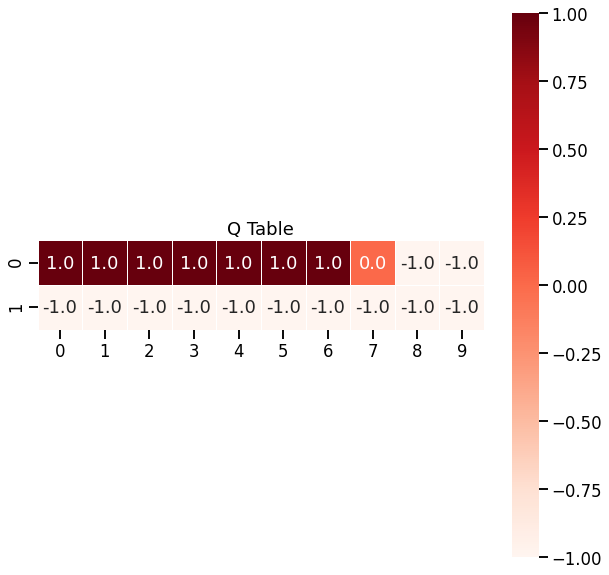

In [21]:
states_display(policy, title="Q Table", cbar=True)

In [45]:
policy  = np.array([best_agents[0].get_action(x) for x in env.states])

In [44]:
policy

array([[ 1, -1,  1, -1,  1, -1],
       [ 1, -1,  0, -1,  0,  0]])